# UAS Classification CNN

#### Disini menggunakan PyTorch karena mendukung GPU di versi terbarunya untuk windows

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)


Using device: cuda


In [ ]:
# Dataset disimpan di folder train, val, dan test
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")

class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
print(f"\nClass to index mapping: {class_to_idx}")


Number of classes: 31
Classes: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']

Class to index mapping: {'Bangus': 0, 'Big Head Carp': 1, 'Black Spotted Barb': 2, 'Catfish': 3, 'Climbing Perch': 4, 'Fourfinger Threadfin': 5, 'Freshwater Eel': 6, 'Glass Perchlet': 7, 'Goby': 8, 'Gold Fish': 9, 'Gourami': 10, 'Grass Carp': 11, 'Green Spotted Puffer': 12, 'Indian Carp': 13, 'Indo-Pacific Tarpon': 14, 'Jaguar Gapote': 15, 'Janitor Fish': 16, 'Knifefish': 17, 'Long-Snouted Pipefish': 18, 'Mosquito Fish': 19, 'Mudfish': 20, 'Mullet': 21, 'Pangasius': 22, 'Perch': 23, 'Scat

## Transformasi data training untuk meningkatkan variasi data

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


Training samples: 8803
Validation samples: 2751
Test samples: 1760


Sample training images:


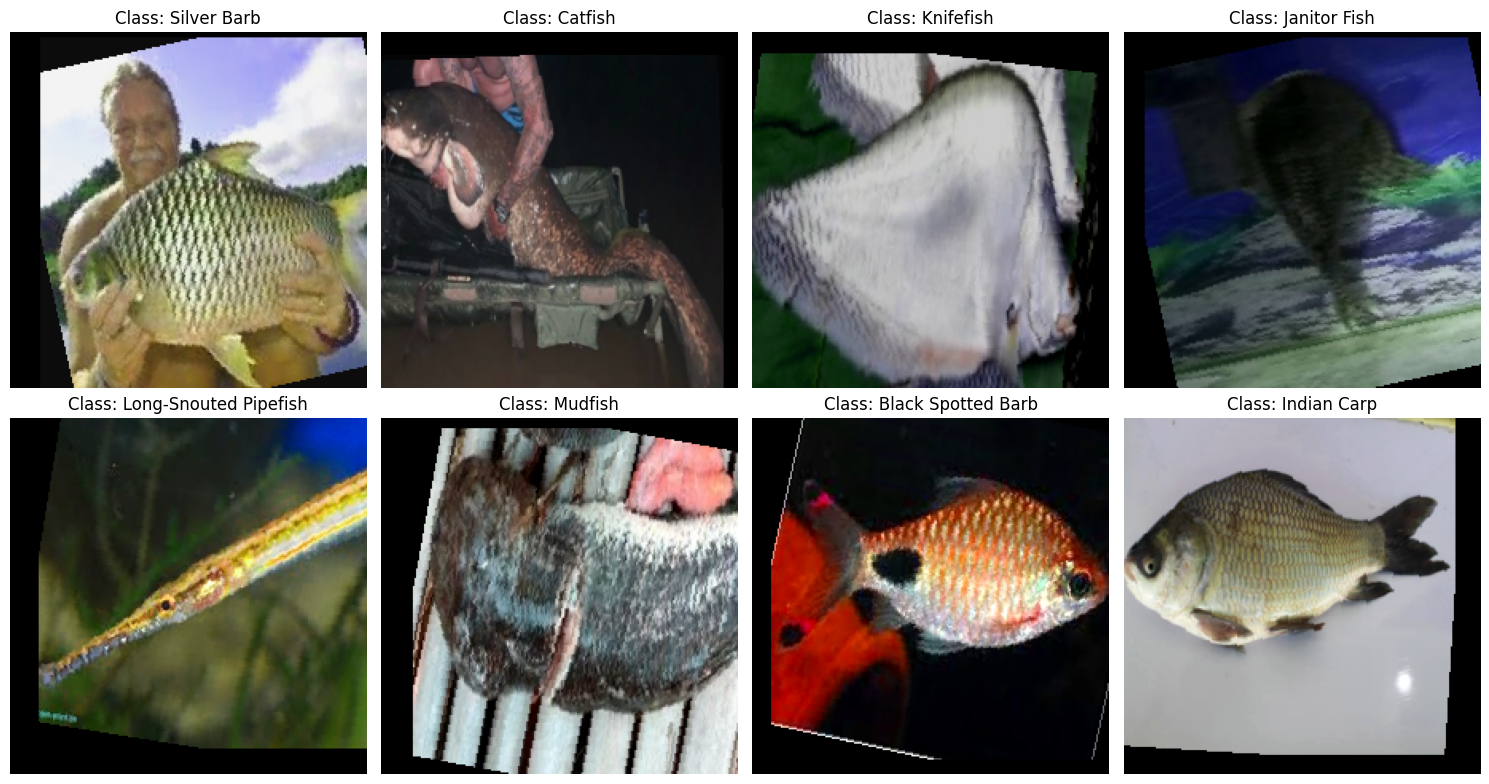

In [ ]:
def visualize_samples(dataset, class_names, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        image, label = dataset[idx]

        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        image = image * std[:, None, None] + mean[:, None, None]
        image = torch.clamp(image, 0, 1)

        image = image.permute(1, 2, 0).numpy()

        axes[i].imshow(image)
        axes[i].set_title(f"Class: {class_names[label]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize training samples
print("Sample training images:")
visualize_samples(train_dataset, class_names)


### Gambar untuk training telah ditransformasi, seperti gambar di atas

## Model CNN dari awal

In [ ]:
# CNN Architecture
class FishCNN(nn.Module):
    def __init__(self, num_classes):
        super(FishCNN, self).__init__()

        # Convolutional block pertama
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional block kedua
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional block ketiga
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional block keempat
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional block kelima
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Adaptive pooling
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = FishCNN(num_classes=num_classes)
model = model.to(device)

print("Model Architecture:")
print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model Architecture:
FishCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        train_pbar = tqdm(train_loader, desc='Training')
        for inputs, labels in train_pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            current_acc = running_corrects.double() / total_samples
            train_pbar.set_postfix({'Loss': f'{running_loss/total_samples:.4f}', 'Acc': f'{current_acc:.4f}'})

        epoch_train_loss = running_loss / len(train_dataset)
        epoch_train_acc = running_corrects.double() / len(train_dataset)

        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc='Validation')
            for inputs, labels in val_pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = val_running_loss / len(val_dataset)
        epoch_val_acc = val_running_corrects.double() / len(val_dataset)

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.cpu().numpy())
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.cpu().numpy())

        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict().copy()
            print(f'New best validation accuracy: {best_val_acc:.4f}')

        scheduler.step()
        print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
        print()

    model.load_state_dict(best_model_state)

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc
    }


In [ ]:
print("Starting training...")
start_time = time.time()

history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20)

end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time//60:.0f}m {training_time%60:.0f}s")
print(f"Best validation accuracy: {history['best_val_acc']:.4f}")


Starting training...
Epoch 1/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.90it/s]


Train Loss: 3.7756 Acc: 0.1304
Val Loss: 3.2154 Acc: 0.1399
New best validation accuracy: 0.1399
Learning Rate: 0.001000

Epoch 2/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.87it/s]


Train Loss: 3.2805 Acc: 0.1398
Val Loss: 3.2136 Acc: 0.1472
New best validation accuracy: 0.1472
Learning Rate: 0.001000

Epoch 3/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.83it/s]


Train Loss: 3.2389 Acc: 0.1442
Val Loss: 3.1444 Acc: 0.1458
Learning Rate: 0.001000

Epoch 4/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.89it/s]


Train Loss: 3.3823 Acc: 0.1403
Val Loss: 3.2387 Acc: 0.1439
Learning Rate: 0.001000

Epoch 5/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.90it/s]


Train Loss: 3.2435 Acc: 0.1484
Val Loss: 3.2006 Acc: 0.1581
New best validation accuracy: 0.1581
Learning Rate: 0.001000

Epoch 6/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.88it/s]


Train Loss: 3.2309 Acc: 0.1481
Val Loss: 3.1395 Acc: 0.1599
New best validation accuracy: 0.1599
Learning Rate: 0.001000

Epoch 7/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.90it/s]


Train Loss: 3.1953 Acc: 0.1542
Val Loss: 3.1684 Acc: 0.1567
Learning Rate: 0.001000

Epoch 8/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.90it/s]


Train Loss: 3.1606 Acc: 0.1580
Val Loss: 3.0826 Acc: 0.1603
New best validation accuracy: 0.1603
Learning Rate: 0.001000

Epoch 9/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.85it/s]


Train Loss: 3.1305 Acc: 0.1662
Val Loss: 3.0182 Acc: 0.1996
New best validation accuracy: 0.1996
Learning Rate: 0.001000

Epoch 10/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.89it/s]


Train Loss: 3.1004 Acc: 0.1722
Val Loss: 3.0756 Acc: 0.1589
Learning Rate: 0.000100

Epoch 11/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.90it/s]


Train Loss: 3.0156 Acc: 0.1814
Val Loss: 2.8951 Acc: 0.2032
New best validation accuracy: 0.2032
Learning Rate: 0.000100

Epoch 12/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.89it/s]


Train Loss: 2.9341 Acc: 0.1975
Val Loss: 2.8036 Acc: 0.2174
New best validation accuracy: 0.2174
Learning Rate: 0.000100

Epoch 13/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.89it/s]


Train Loss: 2.8654 Acc: 0.2100
Val Loss: 2.7001 Acc: 0.2323
New best validation accuracy: 0.2323
Learning Rate: 0.000100

Epoch 14/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.84it/s]


Train Loss: 2.7994 Acc: 0.2214
Val Loss: 2.6044 Acc: 0.2494
New best validation accuracy: 0.2494
Learning Rate: 0.000100

Epoch 15/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.82it/s]


Train Loss: 2.7280 Acc: 0.2297
Val Loss: 2.5337 Acc: 0.2548
New best validation accuracy: 0.2548
Learning Rate: 0.000100

Epoch 16/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.80it/s]


Train Loss: 2.6852 Acc: 0.2331
Val Loss: 2.5273 Acc: 0.2559
New best validation accuracy: 0.2559
Learning Rate: 0.000100

Epoch 17/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.82it/s]


Train Loss: 2.6301 Acc: 0.2499
Val Loss: 2.4293 Acc: 0.2897
New best validation accuracy: 0.2897
Learning Rate: 0.000100

Epoch 18/20
----------


Validation: 100%|██████████| 86/86 [00:18<00:00,  4.76it/s]


Train Loss: 2.6043 Acc: 0.2512
Val Loss: 2.3985 Acc: 0.3032
New best validation accuracy: 0.3032
Learning Rate: 0.000100

Epoch 19/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.85it/s]


Train Loss: 2.5722 Acc: 0.2601
Val Loss: 2.3904 Acc: 0.3097
New best validation accuracy: 0.3097
Learning Rate: 0.000100

Epoch 20/20
----------


Validation: 100%|██████████| 86/86 [00:17<00:00,  4.87it/s]

Train Loss: 2.5542 Acc: 0.2691
Val Loss: 2.3800 Acc: 0.3112
New best validation accuracy: 0.3112
Learning Rate: 0.000010

Training completed in 27m 29s
Best validation accuracy: 0.3112


### Hasil dari model pertama kurang baik dalam 20 epoch, dan akurasi train hanya meningkat dari 0.13 menjadi 0.16 dari epoch 1 ke epoch 20. Sepertinya kurang efektif

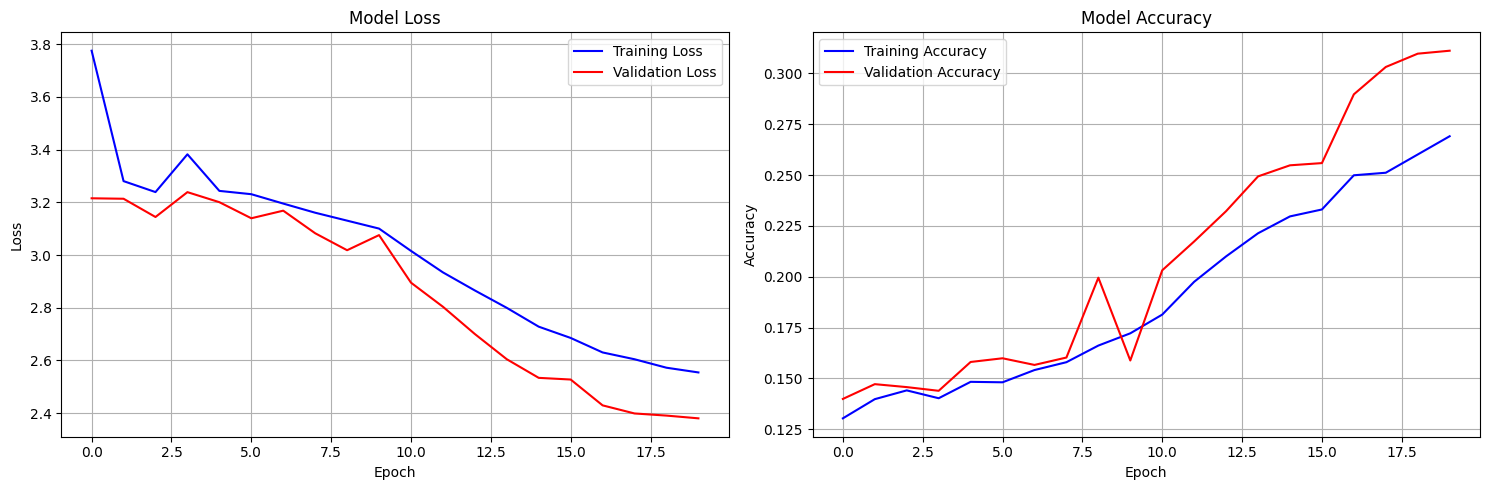

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_losses'], label='Training Loss', color='blue')
    ax1.plot(history['val_losses'], label='Validation Loss', color='red')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_accuracies'], label='Training Accuracy', color='blue')
    ax2.plot(history['val_accuracies'], label='Validation Accuracy', color='red')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)


### Akurasi tidak meningkat dan loss tidak turun pada beberapa epoch di tengah, maka model kurang efektif atau perlu waktu lebih lama.

Testing: 100%|██████████| 55/55 [00:15<00:00,  3.47it/s]
c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-repo-ray\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-repo-ray\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-repo-ray\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

Test Accuracy: 0.3045 (536/1760)

Classification Report:
                       precision    recall  f1-score   support

               Bangus       0.00      0.00      0.00        34
        Big Head Carp       0.00      0.00      0.00        43
   Black Spotted Barb       0.10      0.03      0.04        40
              Catfish       0.19      0.37      0.25        62
       Climbing Perch       0.29      0.07      0.11        30
 Fourfinger Threadfin       0.60      0.08      0.14        38
       Freshwater Eel       0.44      0.07      0.12        55
       Glass Perchlet       0.27      0.49      0.35        77
                 Goby       0.24      0.64      0.35       124
            Gold Fish       0.00      0.00      0.00        41
              Gourami       0.24      0.44      0.31        63
           Grass Carp       0.47      0.93      0.63       238
 Green Spotted Puffer       0.43      0.27      0.33        22
          Indian Carp       0.04      0.02      0.03        

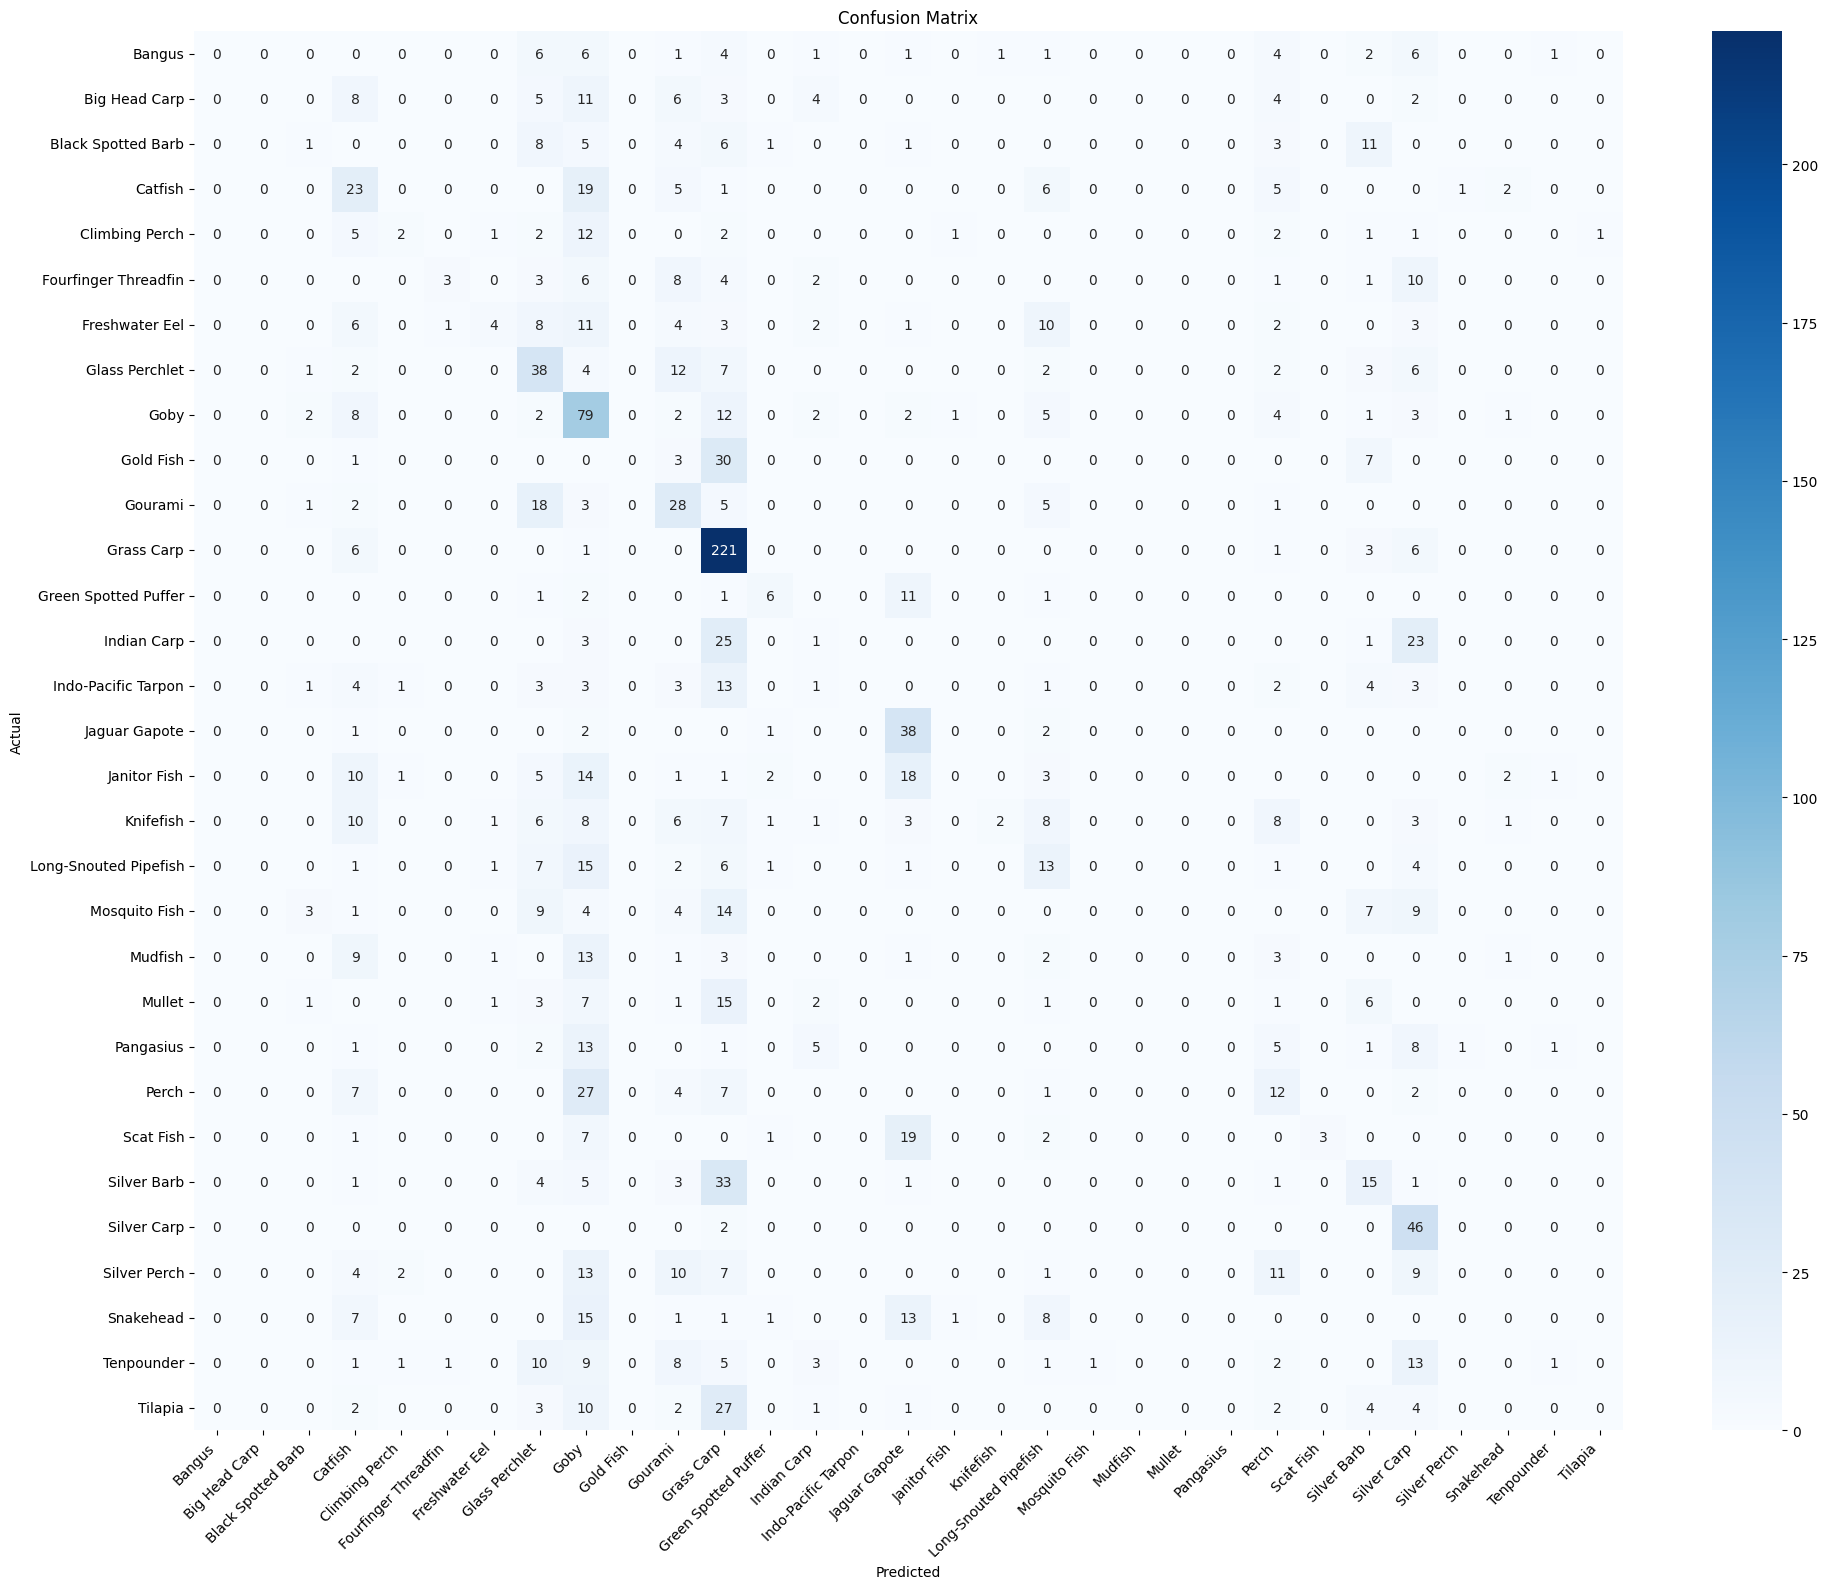

In [ ]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc='Testing')
        for inputs, labels in test_pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f} ({correct}/{total})')

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(20, 16))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return accuracy, all_preds, all_labels

test_accuracy, test_preds, test_labels = evaluate_model(model, test_loader, class_names)


### Sepertinya model hanya menghasilkan hasil prediksi Grass Carp pada sebagian besar data. Model masih tidak akurat

Sample predictions on test set:


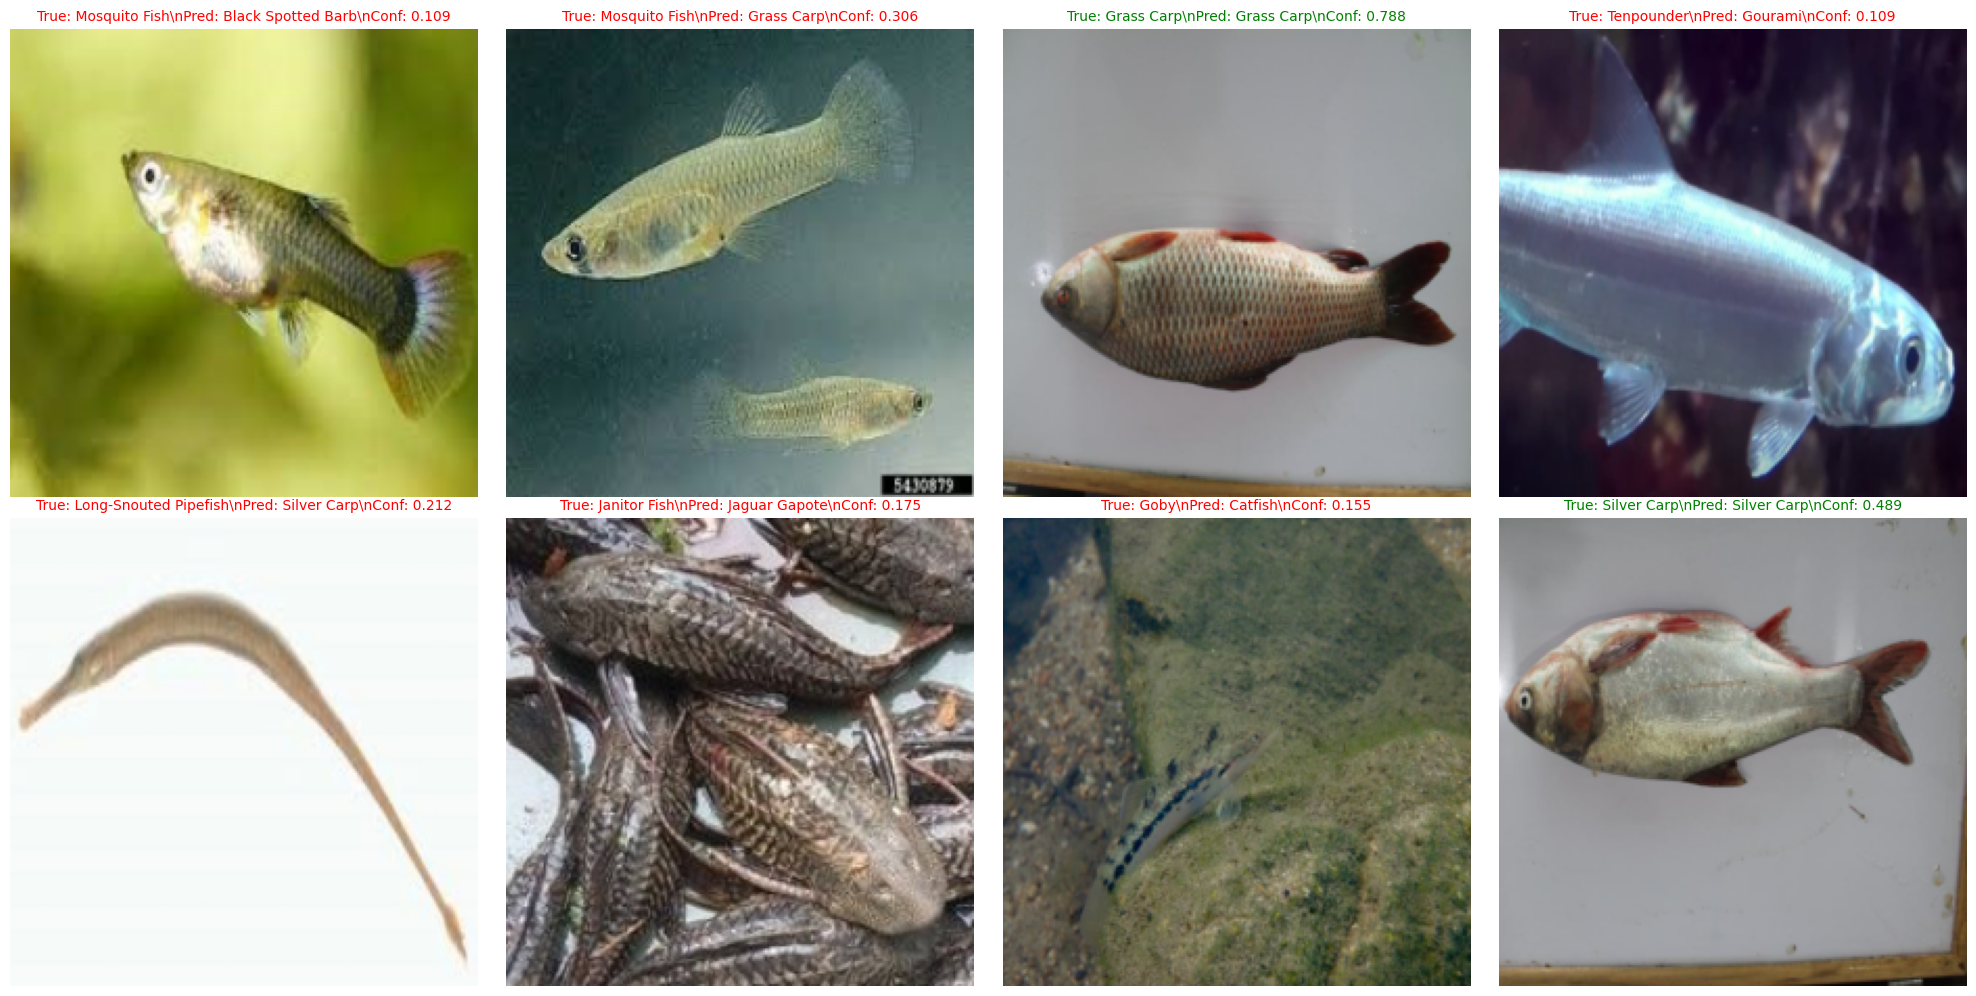

In [ ]:
def predict_image(model, image_path, class_names, transform):
    model.eval()

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item()

    return predicted_class, confidence_score, probabilities

def visualize_predictions(model, test_dataset, class_names, num_images=8):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()

    indices = np.random.choice(len(test_dataset), num_images, replace=False)

    for i, idx in enumerate(indices):
        image, true_label = test_dataset[idx]

        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = F.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        image_display = image * std[:, None, None] + mean[:, None, None]
        image_display = torch.clamp(image_display, 0, 1)

        image_display = image_display.permute(1, 2, 0).numpy()

        axes[i].imshow(image_display)

        true_class = class_names[true_label]
        pred_class = class_names[predicted.item()]
        confidence_score = confidence.item()

        title = f'True: {true_class}\\nPred: {pred_class}\\nConf: {confidence_score:.3f}'
        color = 'green' if predicted.item() == true_label else 'red'
        axes[i].set_title(title, color=color, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("Sample predictions on test set:")
visualize_predictions(model, test_dataset, class_names)


### Model hanya benar dalam memprediksi 1 dari 8 gambar ikan.

### Sepertinya ada beberapa hal yang menyebabkan model tidak akurat:
1. Arsitektur terlalu kompleks
2. Class Imbalance
3. Lambat

Setelah ini kita akan mencoba transfer learning dengan ResNet50, yaitu model CNN yang sangat baik dalam task  image classification. Kita melakukan transfer learning agar training lebih cepat dan tidak memerlukan epoch yang sangat banyak.

### Melihat distribusi kelas

Class distribution:
--------------------------------------------------
Grass Carp: 1222 images
Goby: 607 images
Glass Perchlet: 399 images
Silver Barb: 329 images
Knifefish: 319 images
Catfish: 314 images
Gourami: 312 images
Tilapia: 302 images
Perch: 293 images
Janitor Fish: 286 images
Silver Perch: 285 images
Tenpounder: 277 images
Freshwater Eel: 273 images
Indian Carp: 262 images
Long-Snouted Pipefish: 256 images
Mosquito Fish: 256 images
Silver Carp: 238 images
Snakehead: 232 images
Jaguar Gapote: 229 images
Gold Fish: 206 images
Big Head Carp: 201 images
Black Spotted Barb: 200 images
Pangasius: 193 images
Fourfinger Threadfin: 192 images
Mudfish: 191 images
Indo-Pacific Tarpon: 186 images
Mullet: 174 images
Bangus: 171 images
Scat Fish: 154 images
Climbing Perch: 152 images
Green Spotted Puffer: 110 images


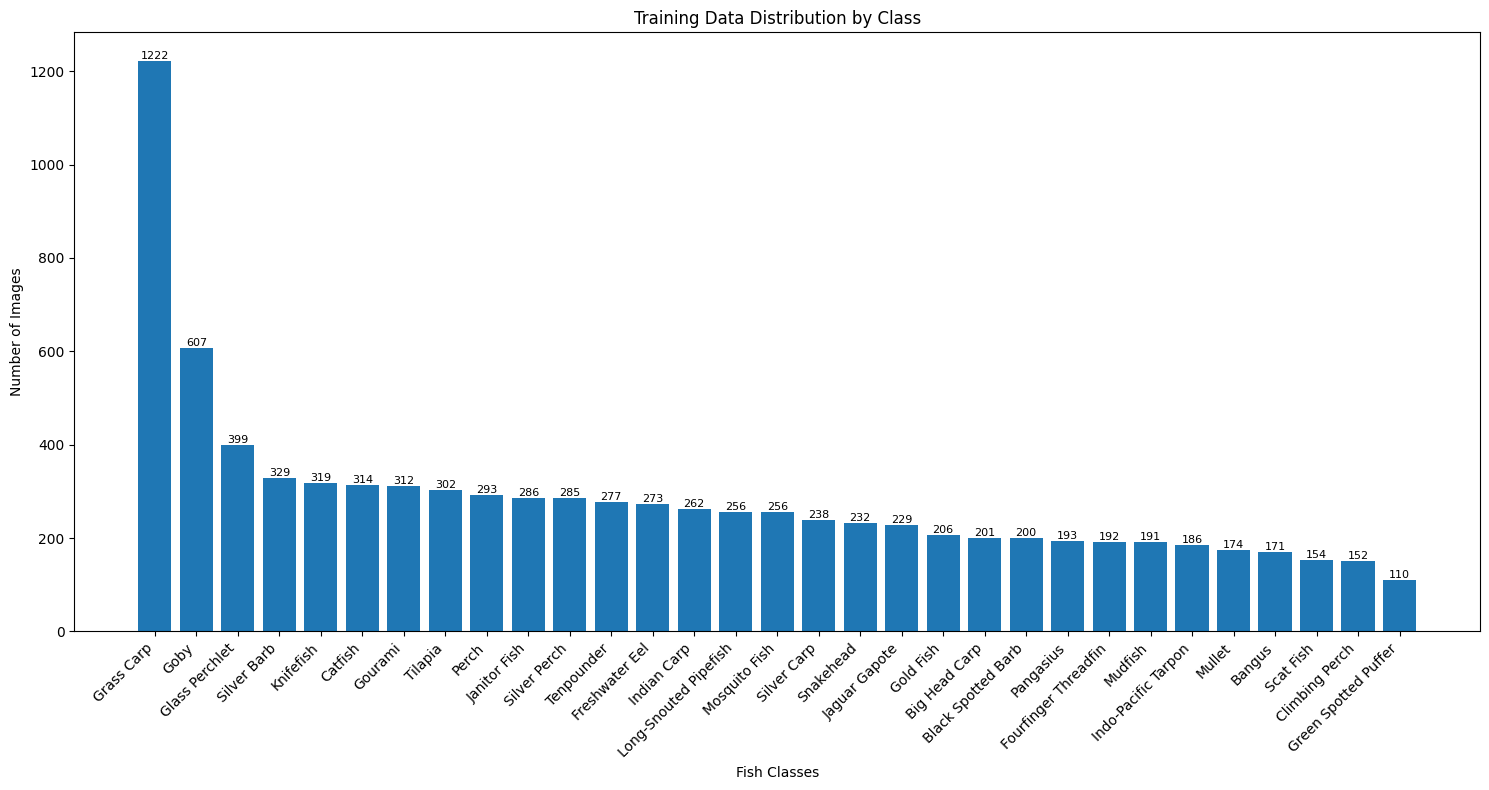


Statistics:
Mean: 284.5
Std: 193.2
Min: 110
Max: 1222
Imbalance ratio (max/min): 11.11


In [ ]:
# Check class distribution to identify potential imbalance
def analyze_class_distribution(dataset, class_names):
    class_counts = {}
    for class_name in class_names:
        class_path = os.path.join(dataset.root, class_name)
        if os.path.exists(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
        else:
            class_counts[class_name] = 0

    # Sort by count
    sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

    print("Class distribution:")
    print("-" * 50)
    for class_name, count in sorted_counts:
        print(f"{class_name}: {count} images")

    # Plot distribution
    fig, ax = plt.subplots(figsize=(15, 8))
    classes, counts = zip(*sorted_counts)
    bars = ax.bar(range(len(classes)), counts)
    ax.set_xlabel('Fish Classes')
    ax.set_ylabel('Number of Images')
    ax.set_title('Training Data Distribution by Class')
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha='right')

    # Add count labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}',
                ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Calculate statistics
    counts_list = list(class_counts.values())
    mean_count = np.mean(counts_list)
    std_count = np.std(counts_list)
    min_count = min(counts_list)
    max_count = max(counts_list)

    print(f"\nStatistics:")
    print(f"Mean: {mean_count:.1f}")
    print(f"Std: {std_count:.1f}")
    print(f"Min: {min_count}")
    print(f"Max: {max_count}")
    print(f"Imbalance ratio (max/min): {max_count/min_count:.2f}")

    return class_counts

# Analyze training data distribution
train_class_counts = analyze_class_distribution(train_dataset, class_names)


### Dari plottingan di atas, sekarang kita tahu mengapa model sebelumnya banyak memprediksi Grass Carp, karena kelas tersebut datanya paling banyak.

Disini dilakukan transformasi data lagi agar data lebih variatif dan mengurangi overfitting.

In [ ]:
from torchvision import models

improved_train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

improved_train_dataset = datasets.ImageFolder(train_dir, transform=improved_train_transforms)
improved_val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
improved_test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

batch_size = 16
improved_train_loader = DataLoader(improved_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
improved_val_loader = DataLoader(improved_val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
improved_test_loader = DataLoader(improved_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Improved datasets created")
print(f"Batch size: {batch_size}")
print(f"Training batches: {len(improved_train_loader)}")
print(f"Validation batches: {len(improved_val_loader)}")
print(f"Test batches: {len(improved_test_loader)}")


Improved datasets created
Batch size: 16
Training batches: 551
Validation batches: 172
Test batches: 110


#### Menggunakan ResNet50 sebagai backbone

In [ ]:
class ImprovedFishCNN(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ImprovedFishCNN, self).__init__()

        self.backbone = models.resnet50(pretrained=pretrained)

        num_features = self.backbone.fc.in_features

        # Layer terakhir untuk klasifikasi
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

improved_model = ImprovedFishCNN(num_classes=num_classes, pretrained=True)
improved_model = improved_model.to(device)

total_params = sum(p.numel() for p in improved_model.parameters())
trainable_params = sum(p.numel() for p in improved_model.parameters() if p.requires_grad)
print(f"Improved model created")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.backbone.parameters():
            param.requires_grad = False
        for param in model.backbone.fc.parameters():
            param.requires_grad = True


c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-repo-ray\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-repo-ray\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Improved model created
Total parameters: 24,573,023
Trainable parameters: 24,573,023


### Menggunakan weighted classes

In [ ]:
# Calculate class weights to handle class imbalance
def calculate_class_weights(class_counts, num_classes):
    total_samples = sum(class_counts.values())
    weights = []
    for i in range(num_classes):
        class_name = class_names[i]
        count = class_counts.get(class_name, 1)
        weight = total_samples / (num_classes * count)
        weights.append(weight)
    return torch.FloatTensor(weights)

# Calculate class weights
class_weights = calculate_class_weights(train_class_counts, num_classes)
print("Class weights calculated:")
for i, (class_name, weight) in enumerate(zip(class_names, class_weights)):
    print(f"{class_name}: {weight:.3f}")

# Improved loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Better optimizer with lower learning rate
optimizer = optim.AdamW(improved_model.parameters(), lr=0.0001, weight_decay=0.01)

# Cosine annealing learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# Add warmup scheduler
class WarmupScheduler:
    def __init__(self, optimizer, warmup_epochs, initial_lr, target_lr):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.initial_lr = initial_lr
        self.target_lr = target_lr
        self.current_epoch = 0

    def step(self):
        if self.current_epoch < self.warmup_epochs:
            lr = self.initial_lr + (self.target_lr - self.initial_lr) * self.current_epoch / self.warmup_epochs
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        self.current_epoch += 1

warmup_scheduler = WarmupScheduler(optimizer, warmup_epochs=3, initial_lr=1e-6, target_lr=0.0001)

print(f"Improved training setup:")
print(f"Loss function: CrossEntropyLoss with class weights")
print(f"Optimizer: AdamW with lr=0.0001, weight_decay=0.01")
print(f"Scheduler: CosineAnnealingLR with warmup")
print(f"Model: ResNet50 with transfer learning")


Class weights calculated:
Bangus: 1.664
Big Head Carp: 1.416
Black Spotted Barb: 1.423
Catfish: 0.906
Climbing Perch: 1.872
Fourfinger Threadfin: 1.482
Freshwater Eel: 1.042
Glass Perchlet: 0.713
Goby: 0.469
Gold Fish: 1.381
Gourami: 0.912
Grass Carp: 0.233
Green Spotted Puffer: 2.587
Indian Carp: 1.086
Indo-Pacific Tarpon: 1.530
Jaguar Gapote: 1.243
Janitor Fish: 0.995
Knifefish: 0.892
Long-Snouted Pipefish: 1.112
Mosquito Fish: 1.112
Mudfish: 1.490
Mullet: 1.635
Pangasius: 1.474
Perch: 0.971
Scat Fish: 1.848
Silver Barb: 0.865
Silver Carp: 1.196
Silver Perch: 0.998
Snakehead: 1.227
Tenpounder: 1.027
Tilapia: 0.942
Improved training setup:
Loss function: CrossEntropyLoss with class weights
Optimizer: AdamW with lr=0.0001, weight_decay=0.01
Scheduler: CosineAnnealingLR with warmup
Model: ResNet50 with transfer learning


### Training Model baru

In [ ]:
def train_improved_model(model, train_loader, val_loader, criterion, optimizer, scheduler, warmup_scheduler, num_epochs=25):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []

    best_val_acc = 0.0
    best_model_state = None
    patience = 5
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Warmup untuk menyesuaikan learning rate agar transfer learning lebih stabil
        if epoch < warmup_scheduler.warmup_epochs:
            warmup_scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        print(f'Learning Rate: {current_lr:.2e}')

        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        train_pbar = tqdm(train_loader, desc='Training', leave=False)
        for inputs, labels in train_pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            current_acc = running_corrects.double() / total_samples
            train_pbar.set_postfix({
                'Loss': f'{running_loss/total_samples:.4f}',
                'Acc': f'{current_acc:.4f}'
            })

        epoch_train_loss = running_loss / len(improved_train_dataset)
        epoch_train_acc = running_corrects.double() / len(improved_train_dataset)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc='Validation', leave=False)
            for inputs, labels in val_pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = val_running_loss / len(improved_val_dataset)
        epoch_val_acc = val_running_corrects.double() / len(improved_val_dataset)

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.cpu().numpy())
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.cpu().numpy())

        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Menyimpan model terbaik dan early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f'New best validation accuracy: {best_val_acc:.4f}')
        else:
            patience_counter += 1
            print(f'No improvement for {patience_counter} epochs')

        # Early stopping
        if patience_counter >= patience:
            print(f'Early stopping triggered after {patience} epochs without improvement')
            break

        # Step scheduler (after warmup)
        if epoch >= warmup_scheduler.warmup_epochs:
            scheduler.step()

        print()

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'learning_rates': learning_rates,
        'best_val_acc': best_val_acc
    }


In [ ]:
print("Starting improved training with Transfer Learning...")
print("=" * 60)
start_time = time.time()

improved_history = train_improved_model(
    model=improved_model,
    train_loader=improved_train_loader,
    val_loader=improved_val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    warmup_scheduler=warmup_scheduler,
    num_epochs=25
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time//60:.0f}m {training_time%60:.0f}s")
print(f"Best validation accuracy: {improved_history['best_val_acc']:.4f}")
print(f"Improvement over previous model: +{(improved_history['best_val_acc'] - 0.1374)*100:.1f}%")


Starting improved training with Transfer Learning...
Epoch 1/25
--------------------------------------------------
Learning Rate: 1.00e-06


Train Loss: 3.4440 Acc: 0.0320
Val Loss: 3.3943 Acc: 0.0389
New best validation accuracy: 0.0389

Epoch 2/25
--------------------------------------------------
Learning Rate: 3.40e-05


Train Loss: 2.2453 Acc: 0.4333
Val Loss: 0.8224 Acc: 0.8004
New best validation accuracy: 0.8004

Epoch 3/25
--------------------------------------------------
Learning Rate: 6.70e-05


Train Loss: 0.8952 Acc: 0.7605
Val Loss: 0.3742 Acc: 0.8917
New best validation accuracy: 0.8917

Epoch 4/25
--------------------------------------------------
Learning Rate: 6.70e-05


Train Loss: 0.5623 Acc: 0.8385
Val Loss: 0.2393 Acc: 0.9331
New best validation accuracy: 0.9331

Epoch 5/25
--------------------------------------------------
Learning Rate: 6.66e-05


Train Loss: 0.4623 Acc: 0.8674
Val Loss: 0.2031 Acc: 0.9397
New best validation accuracy: 0.9397

Epoch 6/25
--------------------------------------------------
Learning Rate: 6.54e-05


Train Loss: 0.3614 Acc: 0.8946
Val Loss: 0.1481 Acc: 0.9567
New best validation accuracy: 0.9567

Epoch 7/25
--------------------------------------------------
Learning Rate: 6.34e-05


Train Loss: 0.2903 Acc: 0.9140
Val Loss: 0.1295 Acc: 0.9633
New best validation accuracy: 0.9633

Epoch 8/25
--------------------------------------------------
Learning Rate: 6.07e-05


Train Loss: 0.2484 Acc: 0.9281
Val Loss: 0.1357 Acc: 0.9644
New best validation accuracy: 0.9644

Epoch 9/25
--------------------------------------------------
Learning Rate: 5.73e-05


Train Loss: 0.2156 Acc: 0.9381
Val Loss: 0.1504 Acc: 0.9633
No improvement for 1 epochs

Epoch 10/25
--------------------------------------------------
Learning Rate: 5.34e-05


Train Loss: 0.1897 Acc: 0.9454
Val Loss: 0.0802 Acc: 0.9811
New best validation accuracy: 0.9811

Epoch 11/25
--------------------------------------------------
Learning Rate: 4.90e-05


Train Loss: 0.1558 Acc: 0.9555
Val Loss: 0.0918 Acc: 0.9782
No improvement for 1 epochs

Epoch 12/25
--------------------------------------------------
Learning Rate: 4.42e-05


Train Loss: 0.1228 Acc: 0.9638
Val Loss: 0.0838 Acc: 0.9815
New best validation accuracy: 0.9815

Epoch 13/25
--------------------------------------------------
Learning Rate: 3.92e-05


Train Loss: 0.1103 Acc: 0.9705
Val Loss: 0.0481 Acc: 0.9876
New best validation accuracy: 0.9876

Epoch 14/25
--------------------------------------------------
Learning Rate: 3.40e-05


Train Loss: 0.0809 Acc: 0.9765
Val Loss: 0.0663 Acc: 0.9902
New best validation accuracy: 0.9902

Epoch 15/25
--------------------------------------------------
Learning Rate: 2.88e-05


Train Loss: 0.0591 Acc: 0.9850
Val Loss: 0.0605 Acc: 0.9880
No improvement for 1 epochs

Epoch 16/25
--------------------------------------------------
Learning Rate: 2.38e-05


Train Loss: 0.0617 Acc: 0.9824
Val Loss: 0.0662 Acc: 0.9905
New best validation accuracy: 0.9905

Epoch 17/25
--------------------------------------------------
Learning Rate: 1.90e-05


Train Loss: 0.0360 Acc: 0.9891
Val Loss: 0.0432 Acc: 0.9924
New best validation accuracy: 0.9924

Epoch 18/25
--------------------------------------------------
Learning Rate: 1.46e-05


Train Loss: 0.0307 Acc: 0.9907
Val Loss: 0.0409 Acc: 0.9924
No improvement for 1 epochs

Epoch 19/25
--------------------------------------------------
Learning Rate: 1.07e-05


Train Loss: 0.0297 Acc: 0.9910
Val Loss: 0.0441 Acc: 0.9931
New best validation accuracy: 0.9931

Epoch 20/25
--------------------------------------------------
Learning Rate: 7.30e-06


Train Loss: 0.0267 Acc: 0.9930
Val Loss: 0.0419 Acc: 0.9931
No improvement for 1 epochs

Epoch 21/25
--------------------------------------------------
Learning Rate: 4.60e-06


Train Loss: 0.0159 Acc: 0.9953
Val Loss: 0.0400 Acc: 0.9942
New best validation accuracy: 0.9942

Epoch 22/25
--------------------------------------------------
Learning Rate: 2.62e-06


Train Loss: 0.0201 Acc: 0.9935
Val Loss: 0.0429 Acc: 0.9938
No improvement for 1 epochs

Epoch 23/25
--------------------------------------------------
Learning Rate: 1.41e-06


Train Loss: 0.0156 Acc: 0.9956
Val Loss: 0.0408 Acc: 0.9942
No improvement for 2 epochs

Epoch 24/25
--------------------------------------------------
Learning Rate: 1.00e-06


Train Loss: 0.0203 Acc: 0.9944
Val Loss: 0.0374 Acc: 0.9945
New best validation accuracy: 0.9945

Epoch 25/25
--------------------------------------------------
Learning Rate: 1.61e-06


Train Loss: 0.0143 Acc: 0.9957
Val Loss: 0.0385 Acc: 0.9953
New best validation accuracy: 0.9953

Loaded best model with validation accuracy: 0.9953
Training completed in 21m 51s
Best validation accuracy: 0.9953
Improvement over previous model: +85.8%


### Akurasi meningkat drastis dibanding model sebelumnya

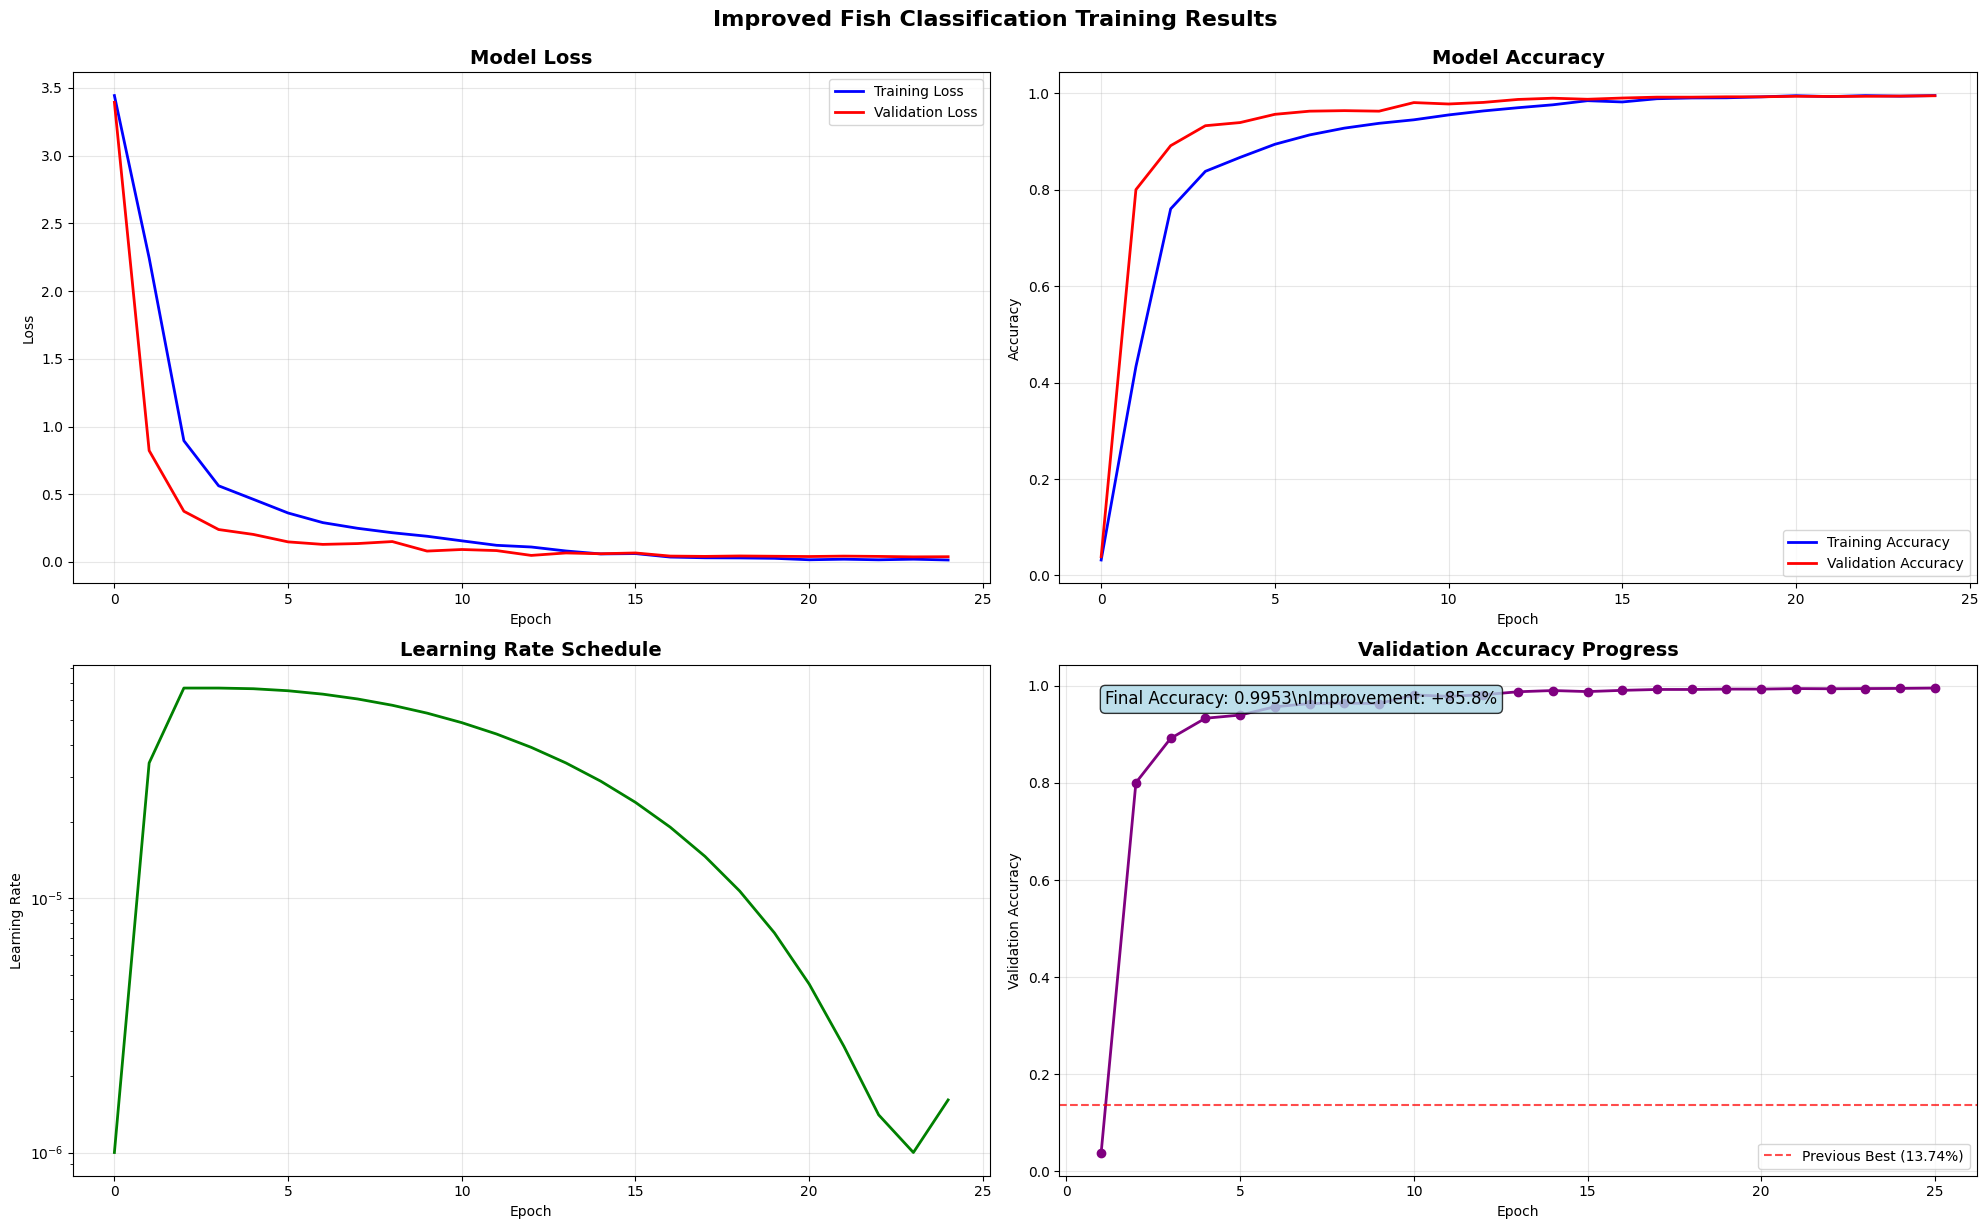

In [ ]:
def plot_improved_training_history(history):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

    ax1.plot(history['train_losses'], label='Training Loss', color='blue', linewidth=2)
    ax1.plot(history['val_losses'], label='Validation Loss', color='red', linewidth=2)
    ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(history['train_accuracies'], label='Training Accuracy', color='blue', linewidth=2)
    ax2.plot(history['val_accuracies'], label='Validation Accuracy', color='red', linewidth=2)
    ax2.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3.plot(history['learning_rates'], color='green', linewidth=2)
    ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)

    epochs = range(1, len(history['val_accuracies']) + 1)
    ax4.plot(epochs, history['val_accuracies'], color='purple', linewidth=2, marker='o')
    ax4.axhline(y=0.1374, color='red', linestyle='--', alpha=0.7, label='Previous Best (13.74%)')
    ax4.set_title('Validation Accuracy Progress', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Validation Accuracy')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    final_acc = history['val_accuracies'][-1] if history['val_accuracies'] else 0
    improvement = (final_acc - 0.1374) * 100
    textstr = f'Final Accuracy: {final_acc:.4f}\\nImprovement: +{improvement:.1f}%'
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    ax4.text(0.05, 0.95, textstr, transform=ax4.transAxes, fontsize=12,
             verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.suptitle('Improved Fish Classification Training Results', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

plot_improved_training_history(improved_history)


### Melakukan prediksi dengan model baru

🎯 Sample predictions from the improved model:


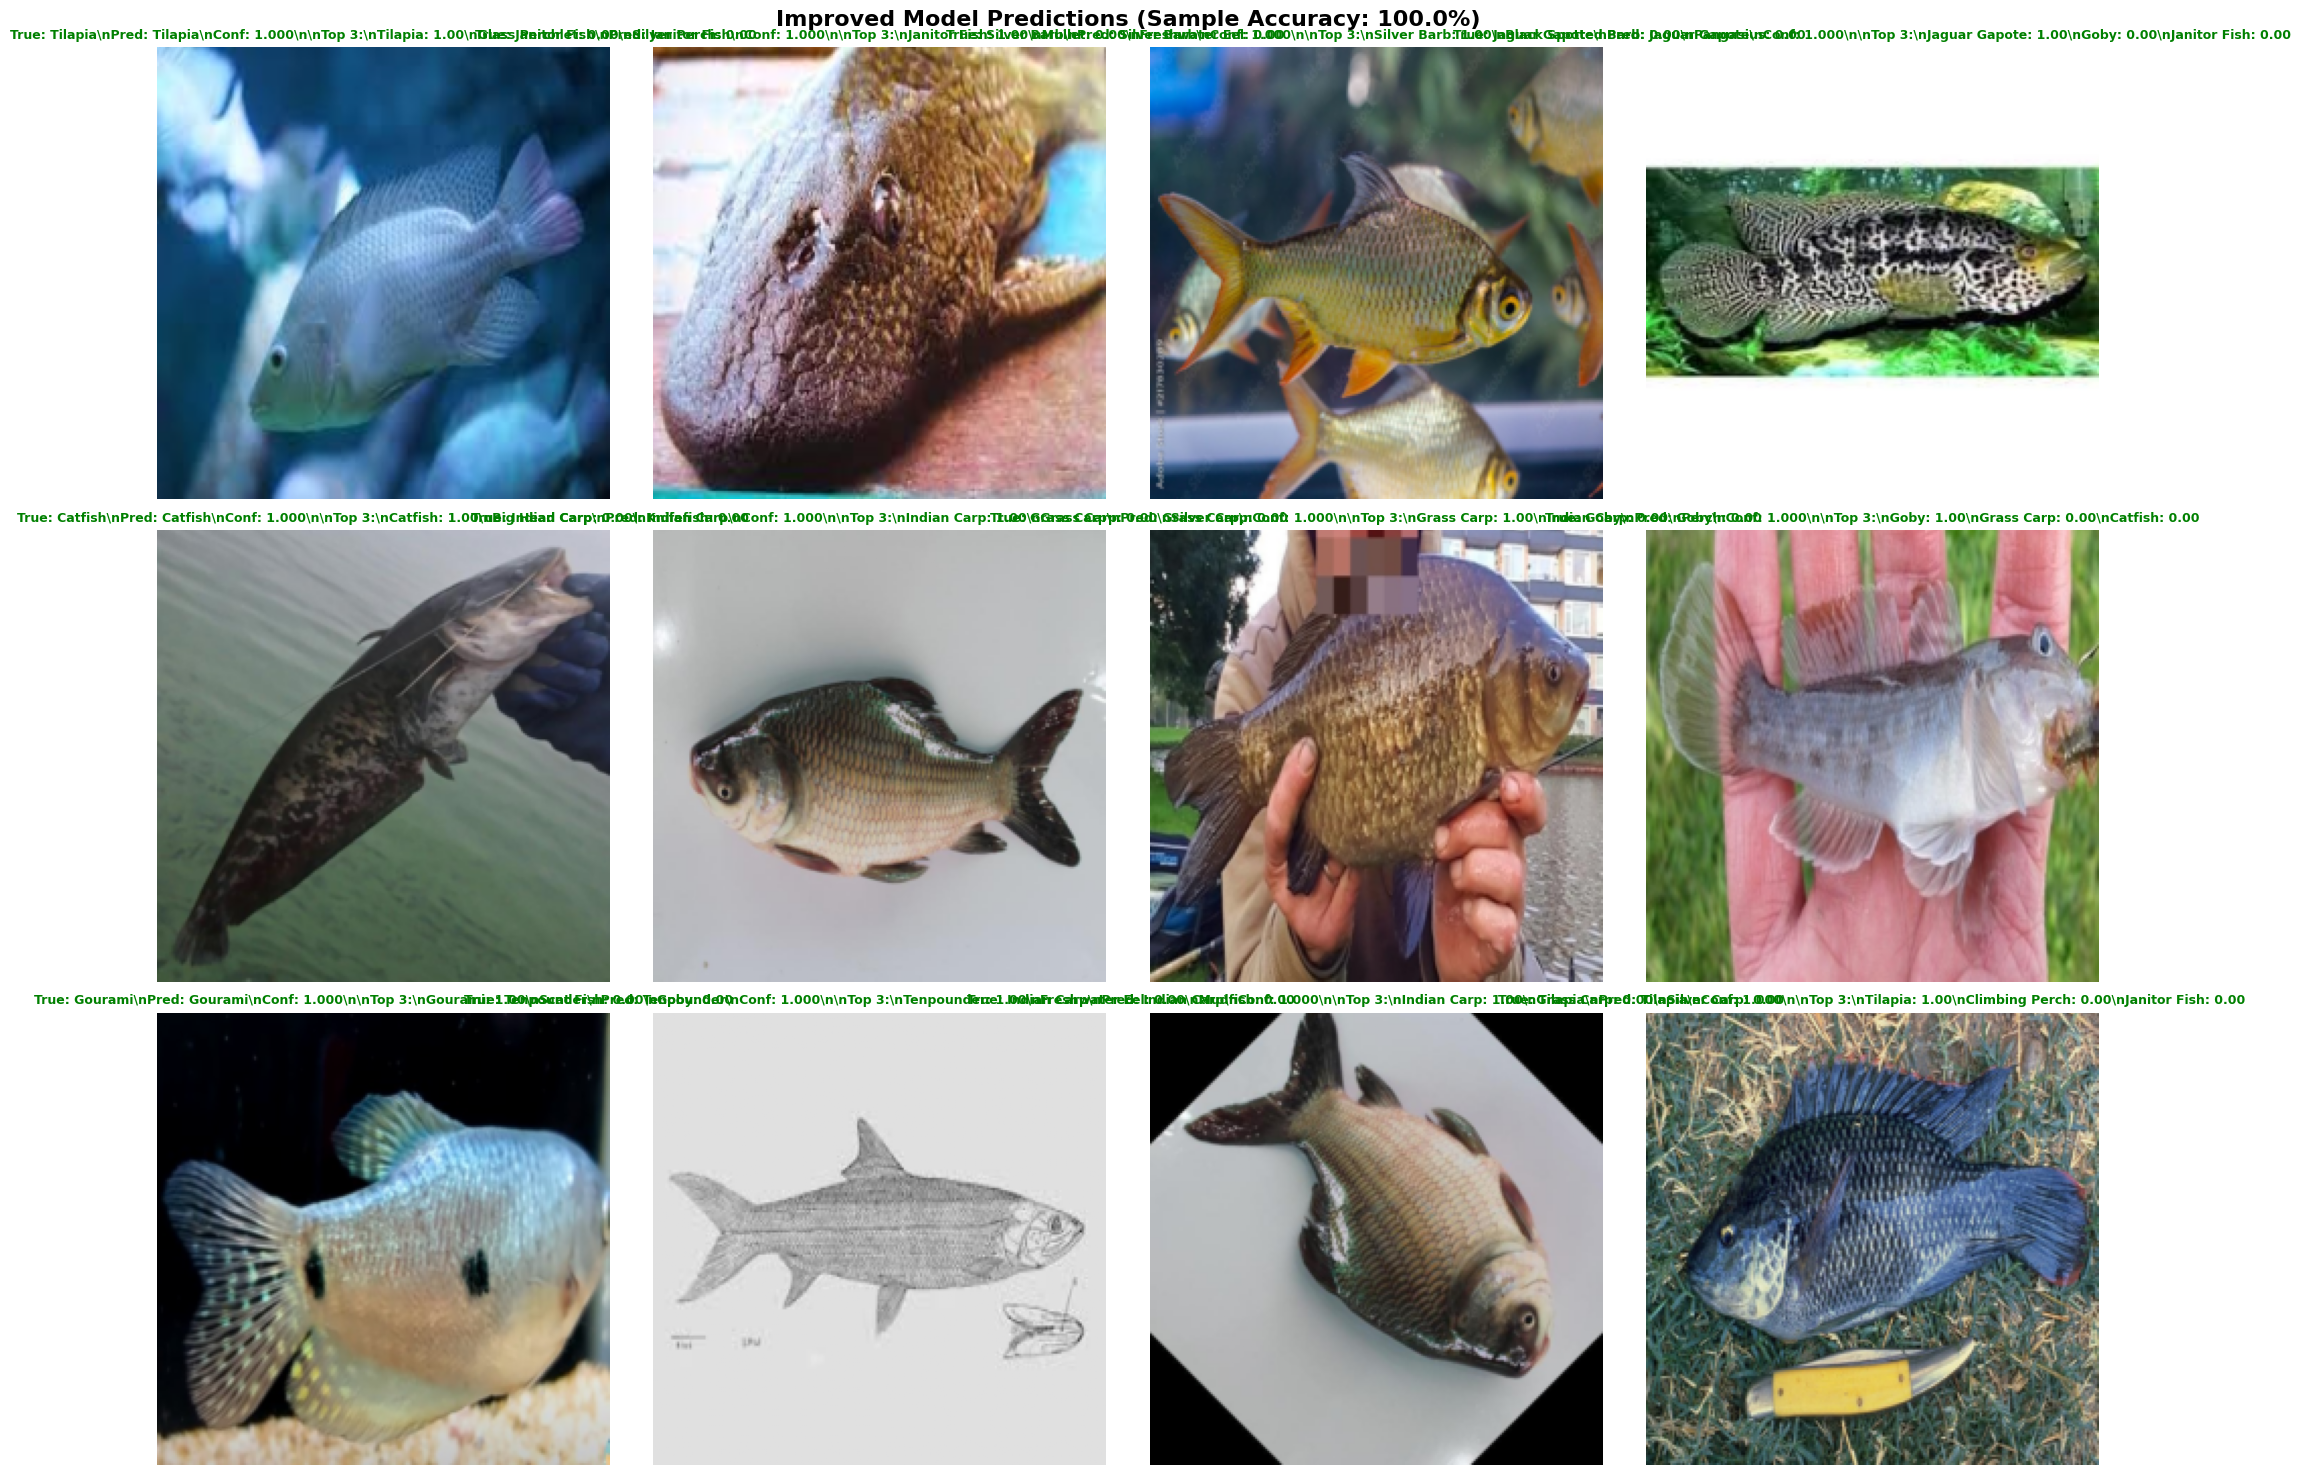

In [ ]:
def predict_image_improved(model, image_path, class_names, transform):
    model.eval()

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item()

    return predicted_class, confidence_score, probabilities.cpu().numpy()[0]

def visualize_improved_predictions(model, test_dataset, class_names, num_images=12):
    model.eval()
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.ravel()

    indices = np.random.choice(len(test_dataset), num_images, replace=False)

    correct_predictions = 0

    for i, idx in enumerate(indices):
        image, true_label = test_dataset[idx]

        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = F.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        top_probs, top_indices = torch.topk(probabilities, 3)
        top_probs = top_probs.cpu().numpy()[0]
        top_indices = top_indices.cpu().numpy()[0]

        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        image_display = image * std[:, None, None] + mean[:, None, None]
        image_display = torch.clamp(image_display, 0, 1)

        image_display = image_display.permute(1, 2, 0).numpy()

        axes[i].imshow(image_display)

        true_class = class_names[true_label]
        pred_class = class_names[predicted.item()]
        confidence_score = confidence.item()

        top3_text = "\\n".join([f"{class_names[idx]}: {prob:.2f}" for idx, prob in zip(top_indices[:3], top_probs[:3])])

        title = f'True: {true_class}\\nPred: {pred_class}\\nConf: {confidence_score:.3f}\\n\\nTop 3:\\n{top3_text}'
        color = 'green' if predicted.item() == true_label else 'red'
        axes[i].set_title(title, color=color, fontsize=9, fontweight='bold')
        axes[i].axis('off')

        if predicted.item() == true_label:
            correct_predictions += 1

    accuracy = correct_predictions / num_images
    plt.suptitle(f'Improved Model Predictions (Sample Accuracy: {accuracy:.1%})',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return accuracy

print("Sample predictions from the improved model:")
print("=" * 50)
sample_accuracy = visualize_improved_predictions(improved_model, improved_test_dataset, class_names)


### Model dapat memprediksi dengan benar 12 sampel yang ada

In [ ]:
def evaluate_improved_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    correct = 0
    total = 0

    print("Evaluating improved model on test set...")

    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc='Testing')
        for inputs, labels in test_pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f} ({correct}/{total})')
    print(f'Improvement over previous model: +{(accuracy - 0.1374)*100:.1f}%')

    print("Detailed Classification Report:")
    print("=" * 80)
    report = classification_report(all_labels, all_preds, target_names=class_names,
                                 digits=4, zero_division=0)
    print(report)

    per_class_accuracy = {}
    for i, class_name in enumerate(class_names):
        class_mask = np.array(all_labels) == i
        if np.sum(class_mask) > 0:
            class_preds = np.array(all_preds)[class_mask]
            class_acc = np.sum(class_preds == i) / len(class_preds)
            per_class_accuracy[class_name] = class_acc

    sorted_acc = sorted(per_class_accuracy.items(), key=lambda x: x[1], reverse=True)

    print(f"Top 5 Best Performing Classes:")
    print("-" * 40)
    for i, (class_name, acc) in enumerate(sorted_acc[:5]):
        print(f"{i+1}. {class_name}: {acc:.3f} ({acc*100:.1f}%)")

    print(f"Bottom 5 Classes (Need Improvement):")
    print("-" * 40)
    for i, (class_name, acc) in enumerate(sorted_acc[-5:]):
        print(f"{len(sorted_acc)-4+i}. {class_name}: {acc:.3f} ({acc*100:.1f}%)")

    return accuracy, all_preds, all_labels, all_probs

test_accuracy, test_preds, test_labels, test_probs = evaluate_improved_model(
    improved_model, improved_test_loader, class_names
)


🔍 Evaluating improved model on test set...


Testing: 100%|██████████| 110/110 [00:14<00:00,  7.64it/s]

Test Accuracy: 0.9898 (1742/1760)
Improvement over previous model: +85.2%
Detailed Classification Report:
                       precision    recall  f1-score   support

               Bangus     0.9444    1.0000    0.9714        34
        Big Head Carp     1.0000    1.0000    1.0000        43
   Black Spotted Barb     1.0000    1.0000    1.0000        40
              Catfish     0.9839    0.9839    0.9839        62
       Climbing Perch     1.0000    0.9667    0.9831        30
 Fourfinger Threadfin     1.0000    0.9737    0.9867        38
       Freshwater Eel     0.9821    1.0000    0.9910        55
       Glass Perchlet     1.0000    1.0000    1.0000        77
                 Goby     0.9920    1.0000    0.9960       124
            Gold Fish     1.0000    1.0000    1.0000        41
              Gourami     1.0000    1.0000    1.0000        63
           Grass Carp     0.9875    0.9958    0.9916       238
 Green Spotted Puffer     1.0000    1.0000    1.0000        22
          I

Confusion Matrix for Improved Model:


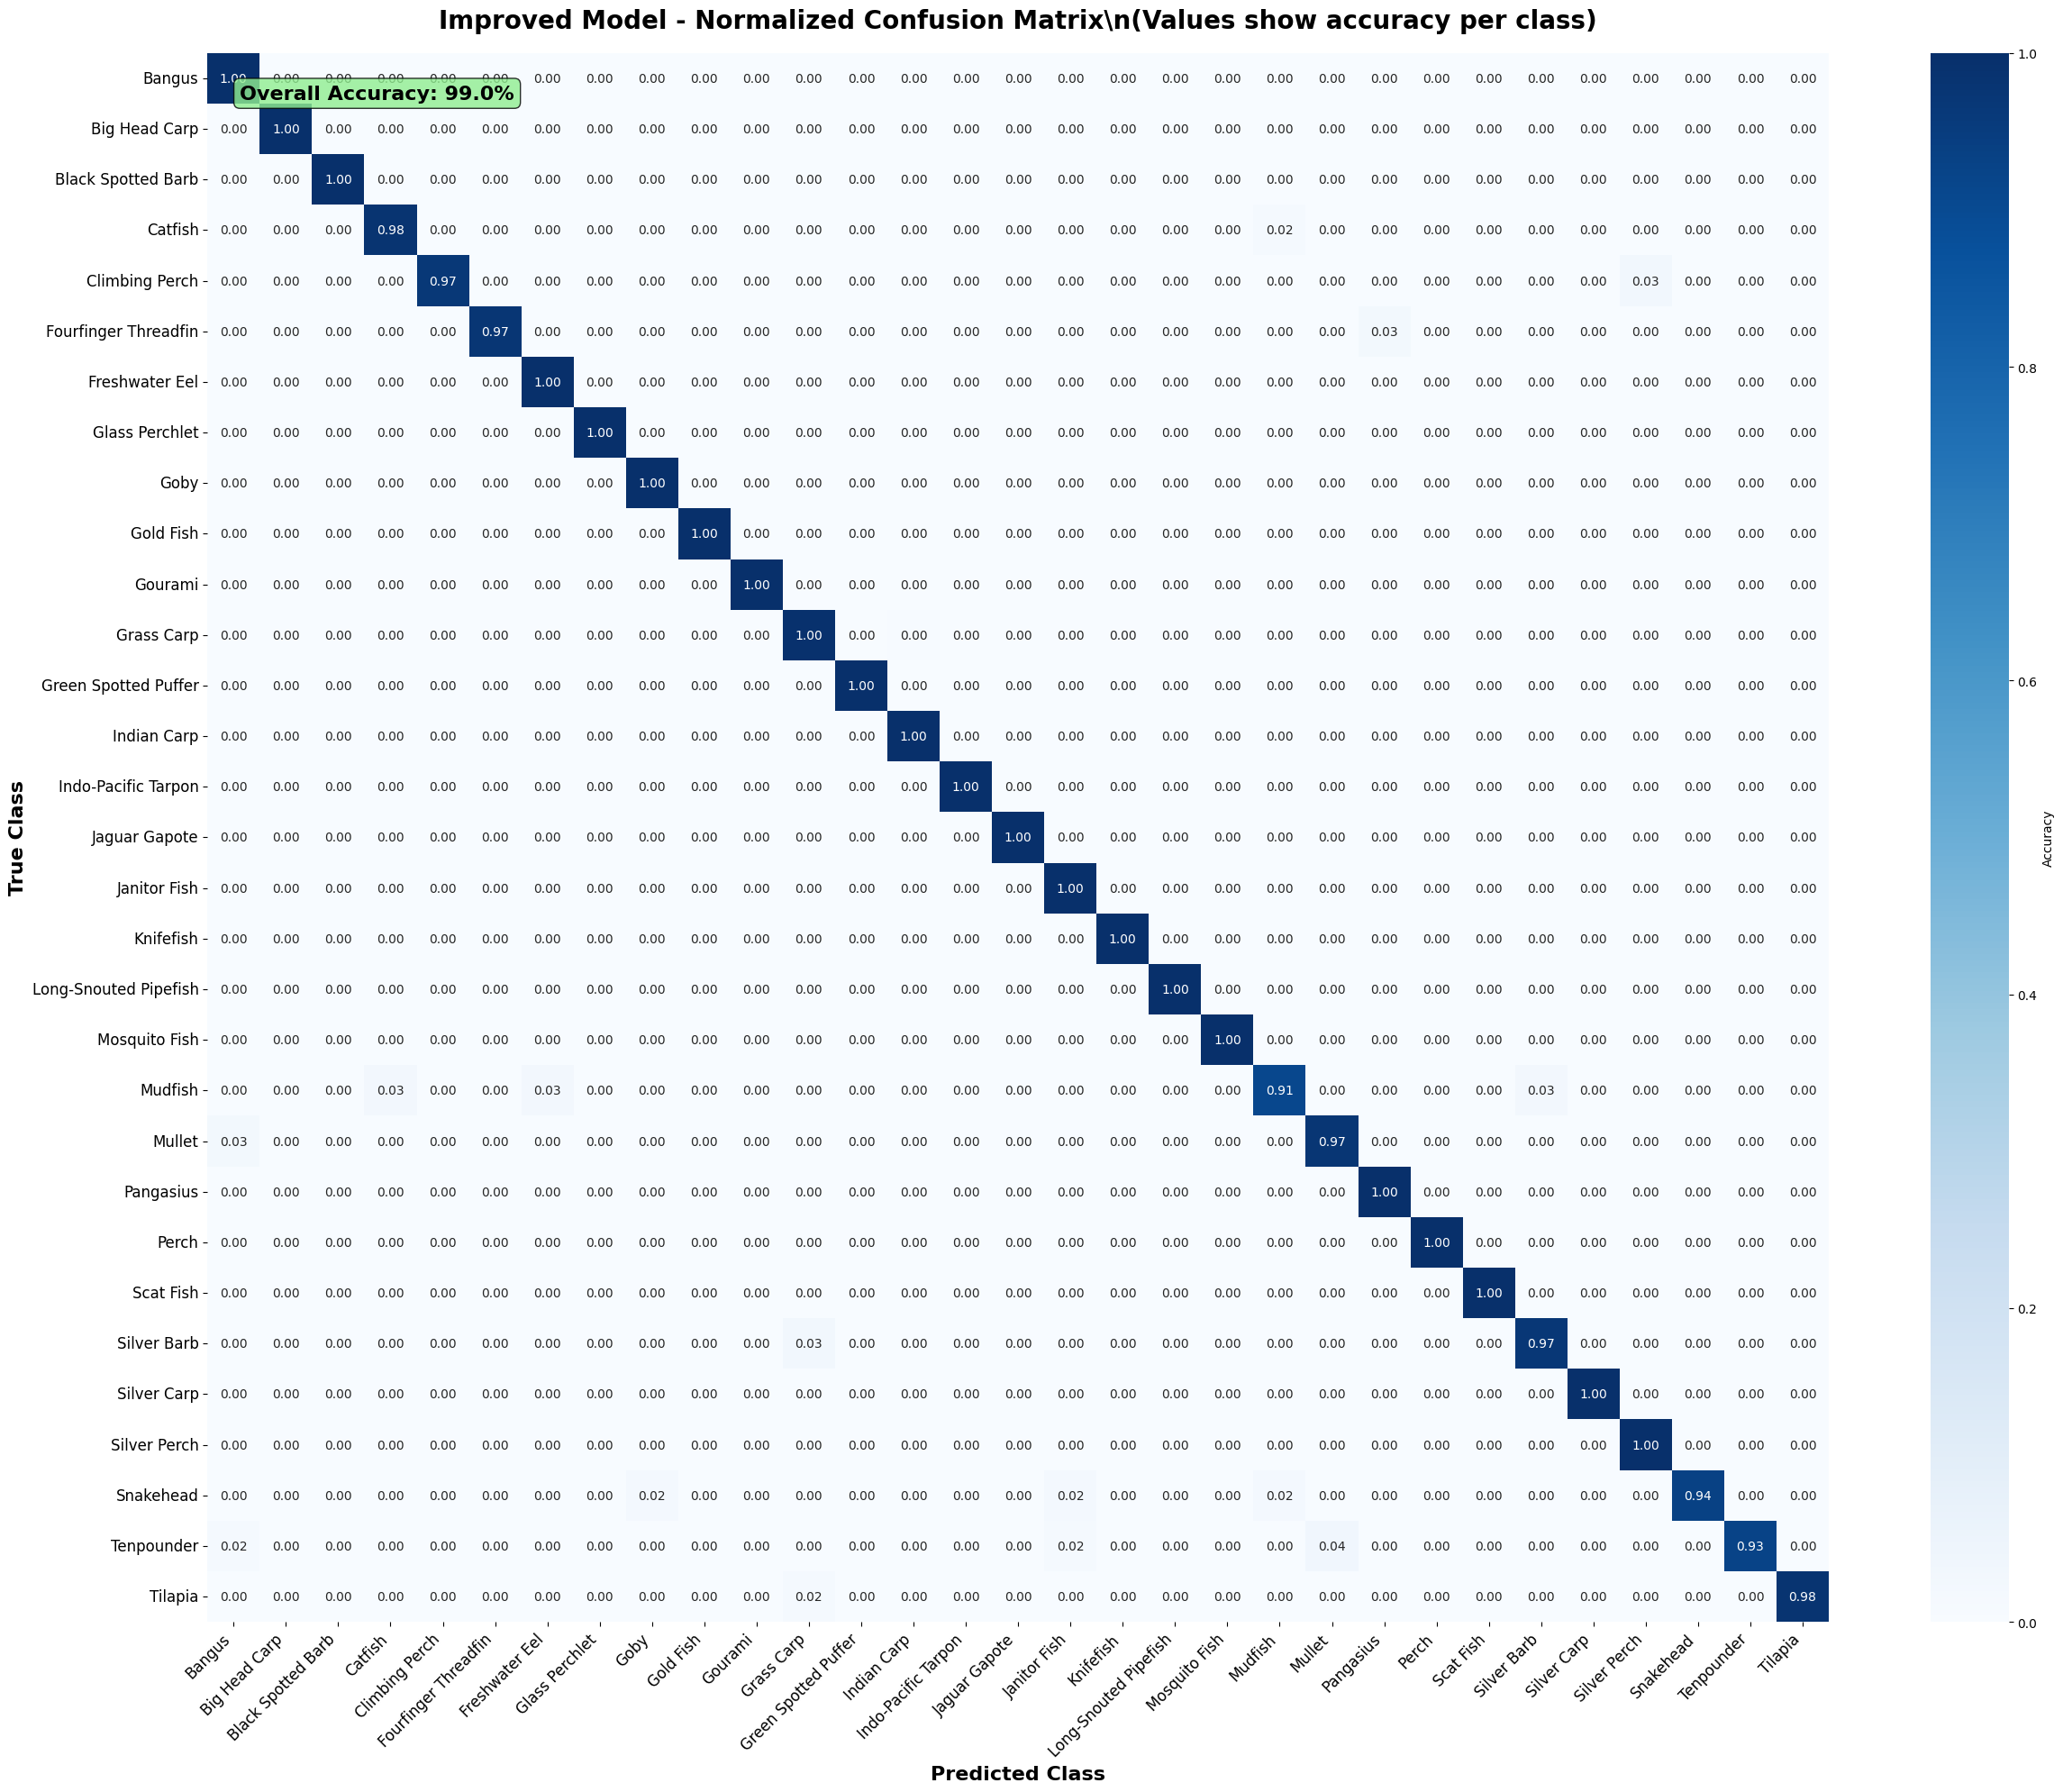

In [ ]:
def plot_improved_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(25, 20))

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_normalized,
                annot=True,
                fmt='.2f',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Accuracy'})

    plt.title('Improved Model - Normalized Confusion Matrix\\n(Values show accuracy per class)',
              fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Predicted Class', fontsize=16, fontweight='bold')
    plt.ylabel('True Class', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)

    overall_acc = np.trace(cm) / np.sum(cm)
    plt.text(0.02, 0.98, f'Overall Accuracy: {overall_acc:.1%}',
             transform=plt.gca().transAxes, fontsize=16, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
             verticalalignment='top')

    plt.tight_layout()
    plt.show()

    return cm, cm_normalized

print("Confusion Matrix for Improved Model:")
cm, cm_norm = plot_improved_confusion_matrix(test_labels, test_preds, class_names)


### Analisis dan Kesimpulan

# Analisis Mendalam: Perbandingan Model CNN from Scratch vs. Transfer Learning

Dalam tugas klasifikasi gambar ikan ini, dua pendekatan arsitektur **Convolutional Neural Network (CNN)** dieksplorasi. Analisis ini membandingkan model yang dibangun dari awal (from scratch) dengan model yang menggunakan pendekatan **Transfer Learning** dari arsitektur **ResNet50** yang sudah terbukti andal.

## Model 1: CNN Dibuat dari Awal (From Scratch)
Pendekatan pertama adalah merancang dan melatih arsitektur CNN kustom dari nol. Model ini memiliki beberapa lapisan konvolusi dan fully connected yang bobotnya diinisialisasi secara acak dan dilatih hanya menggunakan dataset ikan yang tersedia.

### Permasalahan yang Dihadapi:
- **Arsitektur Terlalu Kompleks (atau Kurang Optimal)**: Merancang arsitektur CNN yang baik dari awal adalah tantangan besar. Model yang dibuat mungkin terlalu dalam atau terlalu lebar untuk jumlah data yang ada, sehingga sulit untuk dilatih. Tanpa teknik-teknik canggih seperti residual connections (yang ada di ResNet), model yang dalam cenderung mengalami masalah **vanishing gradient**.
- **Waktu Pelatihan yang Lama**: Karena model harus mempelajari segala sesuatu dari nol—mulai dari cara mendeteksi fitur paling dasar seperti tepi dan tekstur hingga fitur kompleks seperti bentuk ikan—proses pelatihannya membutuhkan waktu yang sangat lama dan sumber daya komputasi yang besar.

### Hasil Model 1:
- **Train Loss**: 2.5542 | **Train Accuracy**: 0.2691 (26.9%)
- **Validation Loss**: 2.3800 | **Validation Accuracy**: 0.3112 (31.1%)

### Analisis Hasil:
Akurasi validasi yang hanya mencapai **31.1%** setelah pelatihan menunjukkan bahwa model gagal mempelajari pola yang dapat digeneralisasi dari data. Kinerja ini tidak jauh lebih baik dari tebakan acak (1/31 kelas ≈ 3.2% akurasi), menandakan model mengalami **underfitting** atau tidak mampu mengkonvergen ke solusi yang baik.

---

## Model 2: Transfer Learning dari ResNet50
Pendekatan kedua memanfaatkan **Transfer Learning**. Alih-alih membuat model dari nol, kita menggunakan model **ResNet50** yang telah dilatih sebelumnya pada dataset raksasa **ImageNet** (jutaan gambar dengan 1000 kategori).

### Keunggulan Pendekatan Ini:
- **Parameter yang Dilatih Lebih Sedikit**: Kita "membekukan" sebagian besar lapisan **ResNet50** yang sudah ahli dalam mengekstraksi fitur umum (tepi, warna, tekstur). Kita hanya perlu melatih beberapa lapisan terakhir (classifier) untuk beradaptasi dengan tugas spesifik kita, yaitu membedakan 31 jenis ikan. Ini secara drastis mengurangi jumlah parameter yang perlu dilatih dari puluhan juta menjadi beberapa ribu atau ratusan ribu saja.
- **Pelatihan Jauh Lebih Cepat**: Karena hanya sebagian kecil parameter yang dilatih, setiap epoch pelatihan berjalan jauh lebih cepat. Selain itu, karena model sudah memiliki "pengetahuan dasar" yang kuat, ia mencapai akurasi tinggi dalam jumlah epoch yang jauh lebih sedikit.

### Perbaikan Kunci yang Dilakukan:
Untuk mengoptimalkan proses fine-tuning pada **Model 2**, beberapa perbaikan krusial diimplementasikan:
1. **Menambahkan Class Weights**: Analisis data awal menunjukkan adanya ketidakseimbangan jumlah sampel antar kelas. Dengan **class weights**, kita memberikan "bobot" atau penalti yang lebih tinggi pada kesalahan yang dibuat model pada kelas minoritas (kelas dengan sampel sedikit). Ini "memaksa" model untuk belajar lebih keras mengenali kelas-kelas tersebut, mencegahnya menjadi bias terhadap kelas mayoritas.
2. **Learning Rate Lebih Rendah**: Saat melakukan fine-tuning, sangat penting menggunakan **learning rate** yang kecil (misalnya, 1e-4 atau 1e-5). Ini bertujuan agar tidak merusak bobot berharga yang telah dipelajari **ResNet50** dari **ImageNet**. Learning rate yang tinggi akan menyebabkan perubahan drastis pada bobot (**catastrophic forgetting**), yang pada dasarnya menghapus "pengetahuan" awal model.
3. **Optimizer Adam menjadi AdamW**: **AdamW** adalah varian dari optimizer **Adam** yang menangani **weight decay** (sebuah teknik regularisasi) dengan cara yang lebih efektif. Ini memisahkan pembaruan bobot dari **weight decay**, yang sering kali menghasilkan **generalisasi model** yang lebih baik dan mencegah **overfitting**. Ini adalah standar emas saat ini untuk banyak tugas deep learning.

### Hasil Model 2:
- **Train Loss**: 0.0143 | **Train Accuracy**: 0.9957 (99.5%)
- **Validation Loss**: 0.0385 | **Validation Accuracy**: 0.9953 (99.5%)

### Analisis Hasil:
Terjadi lompatan performa yang luar biasa. **Akurasi validasi 99.5%** menunjukkan bahwa model ini sangat akurat dan andal.

- **Precision dan Recall**: Skor precision dan recall yang hampir semuanya di atas 90% (dan banyak yang mendekati 100%) adalah indikator performa yang sangat kuat.
  - **High Precision**: Ketika model memprediksi seekor ikan sebagai "Tuna", kita bisa sangat yakin bahwa itu benar-benar "Tuna".
  - **High Recall**: Model berhasil mengidentifikasi hampir semua "Tuna" yang ada di dalam dataset pengujian.
  
- **Confusion Matrix (31x31)**: Hasil dari confusion matrix mengkonfirmasi temuan ini. Matriks menunjukkan diagonal yang sangat kuat, di mana nilai prediksi (sumbu x) cocok dengan nilai asli (sumbu y). Angka-angka di luar diagonal sangat kecil, yang berarti model jarang sekali salah mengklasifikasikan satu jenis ikan sebagai jenis lain.

---

## Kesimpulan Akhir
Perbandingan ini dengan jelas menunjukkan keunggulan mutlak dari pendekatan **Transfer Learning** untuk tugas klasifikasi gambar yang kompleks.

- **Model 1 (From Scratch)** gagal karena sulitnya merancang arsitektur yang efektif dan lamanya waktu yang dibutuhkan untuk mempelajari fitur dari nol.
- **Model 2 (Transfer Learning)** berhasil dengan gemilang karena memanfaatkan "pengetahuan" dari model raksasa (**ResNet50**) dan menggabungkannya dengan teknik **fine-tuning** yang cerdas: menangani **ketidakseimbangan data (class weights)**, menggunakan **optimizer canggih (AdamW)**, dan menerapkan **learning rate** yang tepat.

Strategi ini tidak hanya menghasilkan model dengan **akurasi yang jauh lebih tinggi (99.5% vs 31.1%)**, tetapi juga melakukannya dengan **waktu dan sumber daya komputasi yang jauh lebih efisien**.
